In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [638]:
import pandas as pd
import cv2
import glob
import pydicom
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
PATH = "/home/jeff/notebooks/kaggle/pneumonia/"

In [9]:
df_labels = pd.read_csv('data/stage_1_train_labels.csv')

There are more than 1 bounding boxes per image

In [261]:
np.max(df_labels.groupby(['patientId']).size())

4

In [272]:
df_labels['patientId'].unique().shape

(25684,)

In [286]:
df_labels[['patientId','Target']].drop_duplicates().shape

(25684, 2)

Let's get the largest bounding box per image

In [301]:
df_labels['area'] = df_labels['width']*df_labels['height']

In [455]:
df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index().shape

(25684, 3)

In [432]:
df = pd.DataFrame(df_labels.groupby(['patientId','Target'])['area'].agg(np.max).reset_index())


In [433]:
print(df.shape)
df.head()

(25684, 3)


,patientId,Target,area
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,1,115968.0


In [434]:
assert(np.max(df.groupby(['patientId']).size())==1)

In [435]:
df.columns

Index(['patientId', 'Target', 'area'], dtype='object')

In [436]:
df_labels.columns

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'area'], dtype='object')

In [445]:
df_merged = pd.merge(df, df_labels, on=['patientId','area'])


In [456]:
df_merged.head()

,patientId,Target_x,area,x,y,width,height,Target_y
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,NaN,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,NaN,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,NaN,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,NaN,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,1,115968.0,562.0,152.0,256.0,453.0,1


In [448]:
df_merged.groupby('patientId').size().sort_values(ascending=False).head()

patientId
3db4f481-4e2e-4dd0-a191-a807ee22a39b    2
fffec09e-8a4a-48b1-b33e-ab4890ccd136    1
6a395564-08b0-431f-a97c-514c18b0949e    1
6a2d8b64-cf13-47e2-bed9-41a6b801e1fb    1
6a2e71ca-55a4-4b9e-ae97-a47a070fc89d    1
dtype: int64

In [457]:
df_merged.loc[df_merged['patientId'] == '3db4f481-4e2e-4dd0-a191-a807ee22a39b']

,patientId,Target_x,area,x,y,width,height,Target_y
3426,3db4f481-4e2e-4dd0-a191-a807ee22a39b,1,172215.0,77.0,179.0,267.0,645.0,1
3427,3db4f481-4e2e-4dd0-a191-a807ee22a39b,1,172215.0,465.0,266.0,267.0,645.0,1


In [462]:
df_merged = df_merged.drop(3427)

In [463]:
df_merged.shape

(25684, 8)

lets gut check that we got the largest by looking at one with multiple

In [359]:
df_labels.groupby(['patientId']).size().sort_values(ascending=False).head()

patientId
76f71a93-8105-4c79-a010-0cfa86f0061a    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
dtype: int64

In [363]:
np.asarray(df_labels)[np.where(df_labels['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a')]

array([['76f71a93-8105-4c79-a010-0cfa86f0061a', 619.0, 488.0, 127.0,
        155.0, 1, 19685.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 673.0, 303.0, 106.0,
        145.0, 1, 15370.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 314.0, 461.0, 91.0,
        128.0, 1, 11648.0],
       ['76f71a93-8105-4c79-a010-0cfa86f0061a', 348.0, 303.0, 81.0, 91.0,
        1, 7371.0]], dtype=object)

In [465]:
df_merged.loc[df_merged['patientId'] == '76f71a93-8105-4c79-a010-0cfa86f0061a']

,patientId,Target_x,area,x,y,width,height,Target_y
10079,76f71a93-8105-4c79-a010-0cfa86f0061a,1,19685.0,619.0,488.0,127.0,155.0,1


In [468]:
df_merged = df_merged.reset_index()

In [505]:
df_merged[['patientId','x','y','width','height','Target_x']].head()

,patientId,x,y,width,height,Target_x
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [669]:
df_merged['file_path'] = 'data/train/'+ df_merged['patientId']+'.dcm'

In [670]:
df_merged[['file_path','patientId','x','y','width','height','Target_x']].to_csv('data/train_max_bb_only.csv')

### Split the data

In [507]:
train_files = glob.glob('data/train/*.dcm')

In [508]:
len(train_files)

25684

In [674]:
df_labels = pd.read_csv('data/train_max_bb_only.csv')

In [510]:
N = df_labels.shape[0]
N

25684

In [552]:
validation_indexes = np.random.choice(np.arange(0,N), size=int(N/7))

In [553]:
len(validation_indexes)==int(N/7)

True

In [554]:
np.unique(validation_indexes).shape, int(N/7)

((3411,), 3669)

In [555]:
validation_indexes = np.unique(validation_indexes)

In [556]:
train_indexes = np.asarray([v for v in np.arange(0,N) if v not in validation_indexes])

In [557]:
train_indexes.shape[0]+ validation_indexes.shape[0]

25684

In [558]:
train_indexes

array([    0,     1,     2, ..., 25681, 25682, 25683])

In [559]:
validation_indexes

array([    8,    10,    13, ..., 25671, 25674, 25678])

In [675]:
train_df = pd.DataFrame(np.asarray(df_labels)[train_indexes])

In [676]:
valid_df = pd.DataFrame(np.asarray(df_labels)[validation_indexes])

In [677]:
valid_df.head()

,0,1,2,3,4,5,6,7
0,8,data/train/008c19e8-a820-403a-930a-bc74a405366...,008c19e8-a820-403a-930a-bc74a4053664,NaN,NaN,NaN,NaN,0
1,10,data/train/009eb222-eabc-4150-8121-d5a6d06b8eb...,009eb222-eabc-4150-8121-d5a6d06b8ebf,NaN,NaN,NaN,NaN,0
2,13,data/train/00c0b293-48e7-4e16-ac76-9269ba535a6...,00c0b293-48e7-4e16-ac76-9269ba535a62,650,511,206,284,1
3,18,data/train/01027bc3-dc40-4165-a6c3-d6be2cb7ca3...,01027bc3-dc40-4165-a6c3-d6be2cb7ca34,NaN,NaN,NaN,NaN,0
4,22,data/train/014b7b58-f641-4477-8bbc-ae6f337745d...,014b7b58-f641-4477-8bbc-ae6f337745d6,NaN,NaN,NaN,NaN,0


In [678]:
train_df.head()

,0,1,2,3,4,5,6,7
0,0,data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,data/train/00322d4d-1c29-4943-afc9-b6754be640e...,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,data/train/00436515-870c-4b36-a041-de91049b9ab...,00436515-870c-4b36-a041-de91049b9ab4,562,152,256,453,1


In [679]:
np.where(df_labels['Target_x']==0)[0].shape, np.where(df_labels['Target_x']==1)[0].shape

((20025,), (5659,))

In [680]:
np.where(df_labels['Target_x']==0)[0].shape[0]/np.where(df_labels['Target_x']==1)[0].shape[0]

3.5386110620250926

In [681]:
np.where(valid_df[7]==0)[0].shape, np.where(valid_df[7]==1)[0].shape

((2664,), (747,))

In [682]:
np.where(valid_df[7]==0)[0].shape[0]/ np.where(valid_df[7]==1)[0].shape[0]

3.566265060240964

In [683]:
np.where(train_df[7]==0)[0].shape, np.where(train_df[7]==1)[0].shape

((17361,), (4912,))

In [684]:
np.where(train_df[7]==0)[0].shape[0]/ np.where(train_df[7]==1)[0].shape[0]

3.5344055374592833

In [685]:
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')

In [686]:
train_df.head()

,0,1,2,3,4,5,6,7
0,0,data/train/0004cfab-14fd-4e49-80ba-63a80b6bddd...,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,1,data/train/00313ee0-9eaa-42f4-b0ab-c148ed3241c...,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,2,data/train/00322d4d-1c29-4943-afc9-b6754be640e...,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,3,data/train/003d8fa0-6bf1-40ed-b54c-ac657f8495c...,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,4,data/train/00436515-870c-4b36-a041-de91049b9ab...,00436515-870c-4b36-a041-de91049b9ab4,562,152,256,453,1


### Create Data Loader

- https://keras.io/preprocessing/image/

We need something that will yield a batch of images and labels one at a time

For example: we might have a class that accepts a list of files and their targets, batchsize, and a boolean (random true/false)

In [760]:
class CustomImageDataLoader():
    def __init__(self, file_paths, targets, sz=256, bs=64, channels=1, shuffle=False):
        """
        args:
         - file_paths: iterable of file paths (ie. array or list)
         - targets: np.array of targets (order should correspond with the correct input file)
         - sz: image size
         - bs: batch size
         - channels: number of image channels (ie. 1 or 3)
         - shuffle: whether or not to shuffle the data
        """
        self.N = len(file_paths)
        self.file_paths = file_paths
        self.sz = sz
        self.bs = bs
        self.shuffle = shuffle
        self.channels = channels
        self.all_targets = targets
        self.inputs = np.zeros((self.bs, self.sz, self.sz, self.channels))
        self.targets = np.zeros((self.bs,)+targets.shape[1:])
        self.total_batches = math.ceil(self.N/self.bs)
        self.reset()
        
    def reset(self):
        self.batch_index = 0
        self.order = np.random.permutation(self.N) if self.shuffle else np.arange(self.N)
        
    def next(self):
        bs = self.bs if self.batch_index < self.total_batches-1 or not self.N%self.bs else self.N%self.bs
        offset = self.batch_index*self.bs
        for i in range(bs):
            idx = self.order[offset + i]
            dicom_im = pydicom.dcmread(self.file_paths[idx])
            self.inputs[i] = np.expand_dims( cv2.resize(dicom_im.pixel_array, (self.sz,self.sz)), -1)
            self.targets[i] = self.all_targets[idx]
        self.batch_index += 1
        if self.batch_index == self.total_batches: self.reset()
        return self.inputs[:bs], self.targets[:bs]
    
    def __iter__(self): return self

    def __next__(self, *args, **kwargs): return self.next(*args, **kwargs)

### Quick test of the data loader with a small subset of the data

In [761]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3)

In [762]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

In [763]:
x,y = next(dl)
x,y = next(dl)
x,y = next(dl)
x.shape, y.shape

((1, 256, 256, 1), (1,))

In [764]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

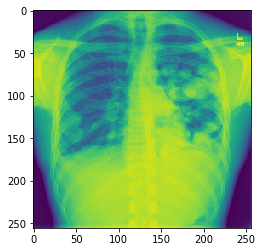

In [765]:
plt.imshow(np.squeeze(x[2]))

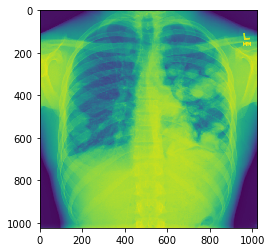

In [766]:
plt.imshow(pydicom.dcmread(train_df[1][2]).pixel_array)

In [767]:
dl = CustomImageDataLoader(train_df[1][:10], train_df[7][:10], bs=3, shuffle=True)

In [768]:
x,y = next(dl)
x.shape, y.shape

((3, 256, 256, 1), (3,))

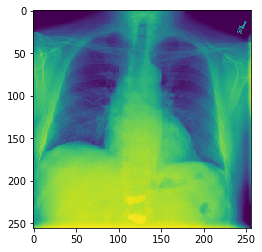

In [769]:
plt.imshow(np.squeeze(x[2])) #this will likely be a different image since we shuffled the data

### Create Model Architecture

### Train Model

### Create Submission